In [1]:
import numpy as np
import h5py
import os
# os.chdir("/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_1_25_222_487664663/genetic_alg/neuron_genetic_alg/neuron_files/modfiles/")
# from neuron import h
import bluepyopt as bpop
import nrnUtils
import score_functions as sf
import efel
import pandas as pd
#import ap_tuner as tuner
from config import *
import allensdk.core.json_utilities as ju
# from biophys_optimize.utils import Utils
from allensdk.model.biophysical.utils import create_utils
import allensdk.model.biophysical.runner as runner
import allensdk.core.json_utilities as ju

from biophys_optimize.environment import NeuronEnvironment
import time
import pickle
import matplotlib.pyplot as plt
import math

import importlib
import allensdk.model.biophysical.utils
from matplotlib.backends.backend_pdf import PdfPages
importlib.reload(allensdk.model.biophysical.utils)
from allensdk.model.biophysical.utils import create_utils
import plot_helper as ph

--No graphics will be displayed.


../../stims/stims_487664663.hdf5 STIM PTA
[b'13' b'562' b'522' b'533' b'573' b'582' b'553' b'593' b'572' b'71'] orig stim set
[b'13' b'562' b'522' b'533' b'573' b'582' b'553' b'593' b'572' b'71'] STIMS IN USE


In [2]:
objectives_path = '/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/objectives/allen487664663_objectives.hdf5'
bbp_passive_score_path = '../../scores/'
bbp_passive_plot_path = './plots_prev_bounds'
os.makedirs(bbp_passive_plot_path, exist_ok=True)
# ph.plot_comb_scores(objectives_path, bbp_passive_score_path, 'Allen Model', bbp_passive_plot_path)
print('Stims used to train:')
# train_stim_names_passive = h5py.File(objectives_path, 'r')['opt_stim_name_list'][:]
# for e in train_stim_names_passive:
#     print(e.decode('ascii'))
# # plt.ylim(0,300000)

Stims used to train:


In [3]:
objectives_file = h5py.File('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/genetic_alg/objectives/multi_stim_without_sensitivity_allen_full_09_12_22_stims.hdf5','r')
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
stim_file = h5py.File('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/stims/stims_487664663.hdf5','r')
opt_stim_name_list = [elem for elem in list(stim_file.keys()) if not 'dt' in elem]

In [4]:
params = ju.read('/global/cscratch1/sd/zladd/allen_optimize/biophys_optimize/biophys_optimize/fit_styles/f9_fit_style.json')
        
maxs = [param['max'] for param in params['channels']] + [param['max'] for param in params['addl_params']] 
mins = [param['min'] for param in params['channels']] + [param['min'] for param in params['addl_params']]
channel_bounds = [{'max': mx, 'min': mn} for mx, mn in zip(maxs,mins)]

def actual_parameters_from_normalized(params, channel_bounds):
        """ Calculate actual values of parameters that have been normalized """
        channels_and_others = channel_bounds
        actual_params = [(p *
            (channels_and_others[i]["max"] -
            channels_and_others[i]["min"]) +
            channels_and_others[i]["min"])
            for i, p in enumerate(params)]
        return actual_params

In [5]:
param_df = pd.read_csv('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/genetic_alg/params/params_allen_full.csv')
mins, maxs = param_df['Lower bound'].values, param_df['Upper bound'].values
bases = maxs / mins
# mins, maxs = np.array([math.log(mins[i],bases[i]) for i in range(len(mins))]), np.array([math.log(maxs[i],bases[i]) for i in range(len(maxs))])


0.095 before
0.095 after
TIMING:  0.5570237636566162
mean res -52.866458143060576
0.165 before
0.165 after
TIMING:  0.5561285018920898
mean res -55.09682549224453
0.165 before
0.165 after
TIMING:  0.5684380531311035
mean res -55.09682549224453
0.165 before


0.165 after
TIMING:  0.5297212600708008
mean res -55.09450434204424


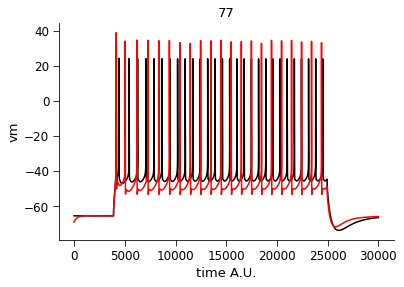

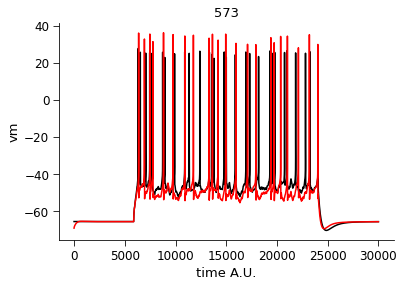

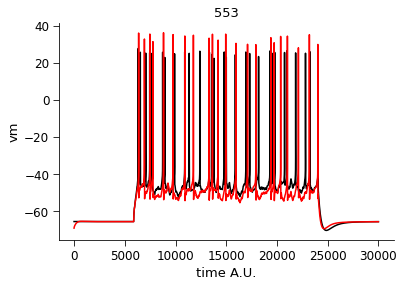

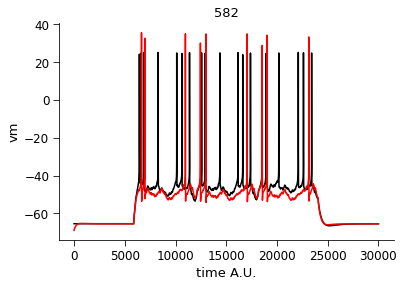

In [7]:
description = runner.load_description(args)
utils = runner.create_utils(description)
h = utils.h

# configure model
manifest = description.manifest
morphology_path = description.manifest.get_path('MORPHOLOGY').encode('ascii', 'ignore')
morphology_path = morphology_path.decode("utf-8")
utils.generate_morphology(morphology_path)

# t_params = ju.read('/global/cscratch1/sd/zladd/allen_optimize/biophys_optimize/test_storage/cell_487664663/orig_fit.json')
# t_params = [p['value'] for p in t_params['genome']]
t_params = pd.read_csv('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/genetic_alg/params/params_allen_full.csv')['Base value'].values

# utils.load_parameters(t_params)
# print(t_params)

pdf = PdfPages('volts_indv_50_allen_model_no_passive.pdf')
# idvs = [5,10,15,20,28, 55]
idvs = [240]

for idv in idvs:
    # idv = 75
    indv_path = f'best_indv_logs/best_indvs_gen_{idv}.pkl'
    with open(indv_path, 'rb') as f:
        params = pickle.load(f)[-1]
    # params  = np.array([math.pow(bases[i], params[i]) for i in range(len(params))])
    # assert not (np.isclose(params,t_params)).all()
    utils.load_parameters(params)
    responses = []
    # opt_stim_name_list = ['77','45','553','18']
    opt_stim_name_list = ['77','573','553','582']
    for sweep in opt_stim_name_list: #[::3]:
        sweep = int(sweep)
        # configure stimulus and recording
        stimulus_path = description.manifest.get_path('stimulus_path')
        run_params = description.data['runs'][0]

        # OPTION 2
        dt = stim_file[str(sweep) + "_dt"][:][0]
        utils.setup_iclamp2(stimulus_path, sweep=sweep, stim=stim_file[str(sweep)], dt=dt)
        if abs(dt*h.nstep_steprun*h.steps_per_ms - 1)  != 0:
                h.steps_per_ms = 1/(dt * h.nstep_steprun)


        vec = utils.record_values()
        tstart = time.time()
        h.finitialize()
        print(utils.h.dt,'before')
        h.run()
        print(utils.h.dt, 'after')



        tstop = time.time()
        print("TIMING: ", tstop - tstart) 
        res =  utils.get_recorded_data(vec)

        # timescale = int(len(res['v']) / 30000)
        res['v'] = res['v']*1000
        
        fig = plt.figure()
        plt.title(sweep)
        print("mean res", np.mean(res['v'][1000:]))
        plt.plot(target_volts_hdf5[str(sweep)][:], color='black', label='target')
        plt.plot(res['v'] , color='red', label='sim')
        plt.ylabel("vm")
        plt.xlabel('time A.U.')
        # pdf.savefig(fig, bbox_inches='tight')
        # plt.close(fig)


        responses.append(res['v'] )
pdf.close()

In [22]:
pdf.close()

In [28]:
names = param_df['Param name'].values

In [30]:
for idx, name in enumerate(names):
    print(name, 'target : ', t_params[idx], ' inferred :',  params[idx])

gbar_Im_soma target :  0.0012383893612445  inferred : 0.0024300158830480936
gbar_Ih_soma target :  0.0006338765849686  inferred : 0.0007276788316425353
gbar_NaTs_soma target :  0.500453361737873  inferred : 0.7120853532739442
gbar_Nap_soma target :  1.758571027409006e-05  inferred : 2.2914227932100712e-05
gbar_K_P_soma target :  0.0006796868759747  inferred : 0.00013856130306077186
gbar_K_T_soma target :  1.559856737237686e-05  inferred : 3.6465497450586315e-05
gbar_SK_soma target :  0.0005304617338248  inferred : 0.00039029782326740364
gbar_Kv3_1_soma target :  0.14322461216868  inferred : 0.1638006076951045
gbar_Ca_HVA_soma target :  0.0001483591621125  inferred : 0.00014149045130746116
gbar_Ca_LVA_soma target :  0.0096001873885489  inferred : 0.04104597231882749
gamma_CaDynamics_soma target :  0.0047872887880014  inferred : 0.0015290978540292647
decay_CaDynamics_soma target :  365.1020624075615  inferred : 410.2953031508955
g_pas__soma target :  1.4062989960779356e-05  inferred : 5.

In [41]:
bases[10]

9680.759477834517

In [49]:
np.mean(responses[-1])

-66.37331948635763

In [7]:
np.mean(responses[-1])

-85.02025954289502

(-100.0, 100.0)

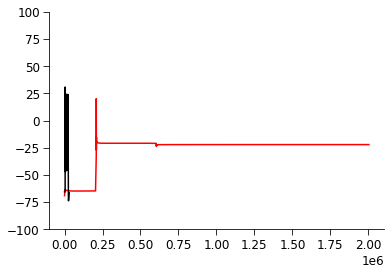

In [8]:
plt.plot(responses[-1], color='red', label='sim')

# plt.plot(t_responses[b'71'], color='black', label='target')

# plt.plot(res['v'], color='red' )
plt.plot(target_volts_hdf5[str(sweep)][:], color='black', label='target')
plt.ylim(-100,100)

In [6]:
from allensdk.core.nwb_data_set import NwbDataSet

not_surrogate_dset = NwbDataSet('/global/cscratch1/sd/zladd/allen_optimize/biophys_optimize/test_storage/cell_487664663/487664661_ephys.nwb')
dset = NwbDataSet('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_2_09_22_487664663/genetic_alg/neuron_genetic_alg/487664663_ephys_sim.nwb')
allen_fitted_params = ju.read('/global/cscratch1/sd/zladd/allen_optimize/biophys_optimize/test_storage/cell_487664663/fit_parameters.json')
fitted_allen_nwb = NwbDataSet('/global/cscratch1/sd/zladd/allen_optimize/biophys_optimize/test_storage/cell_487664663/work/487664663_ephys_sim_reboot.nwb')

In [7]:
sweeps = dset.get_sweep_numbers()

Text(0.5, 1.0, 'Sweep 68 ')

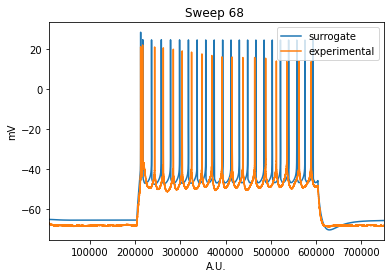

In [8]:
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(dset.get_sweep(71)['response']  * 1000, label='surrogate')
plt.plot(not_surrogate_dset.get_sweep(71)['response']  * 1000, label='experimental')

# plt.plot(responses[-1], color='red', label='sim')

plt.legend(loc='upper right')
plt.xlim(10000, 750000)
plt.savefig('tst.png')
plt.ylabel("mV")
plt.xlabel('A.U.')
plt.title(f"Sweep {68} ")
# plt.savefig('sweep_71.png', bbox_inches='tight', facecolor='white', transparent=False)


In [9]:

def run_stim(sweep, params, utils, stimulus_path):
    # OPTION 1
    utils.load_parameters(params)
    utils.setup_iclamp(stimulus_path, sweep=sweep)
    vec = utils.record_values()
    tstart = time.time()
    h.finitialize()
    h.run()
    tstop = time.time()
    print("TIMING: ", tstop - tstart) 
    res =  utils.get_recorded_data(vec)
    res['v'] = res['v']*1000
    return res['v'] 

In [22]:
allen_fitted_params.keys()

dict_keys(['passive', 'fitting', 'conditions', 'genome'])

In [7]:
with open('responses.pkl','rb') as f:
    responses = pickle.load(f)

In [24]:

# UTILS
description = runner.load_description(args)
utils = runner.create_utils(description)
h = utils.h

# CONFIGURE MODEL
manifest = description.manifest
morphology_path = description.manifest.get_path('MORPHOLOGY').encode('ascii', 'ignore')
morphology_path = morphology_path.decode("utf-8")
utils.generate_morphology(morphology_path)
stimulus_path = description.manifest.get_path('stimulus_path')


idv = 45
# PARAMS
indv_path = f'best_indv_logs/best_indvs_gen_{idv}.pkl'
with open(indv_path, 'rb') as f:
    params = pickle.load(f)[-1]
params = actual_parameters_from_normalized(params, channel_bounds)



# responses = {}
# opt_stim_name_list = ['71']
sweeps = dset.get_sweep_numbers()

for sweep in sweeps:
    sweep = int(sweep)
    if len(dset.get_sweep(sweep)['response']) > 6604001:
        print("SKIPPED : ", sweep)
        continue
    print('processing: ', sweep)
    response = run_stim(sweep, params, utils, stimulus_path)
    responses[sweep] = response
    

processing:  10
TIMING:  7.309754133224487
processing:  11
TIMING:  7.155365943908691
processing:  12
TIMING:  7.186772346496582
processing:  13
TIMING:  7.418930768966675
processing:  14
TIMING:  7.381776332855225
processing:  17
TIMING:  7.22275972366333
processing:  18
TIMING:  7.420320987701416
processing:  19
TIMING:  7.419515132904053
processing:  20
TIMING:  7.306345701217651
processing:  21
TIMING:  7.285842180252075
processing:  23
TIMING:  7.3587563037872314
processing:  24
TIMING:  7.139942169189453
processing:  25
TIMING:  7.265099048614502
processing:  26
TIMING:  7.292147159576416
processing:  27
TIMING:  7.46446418762207
processing:  28
TIMING:  7.784394025802612
processing:  29
TIMING:  7.74608302116394
processing:  31
TIMING:  29.24847960472107
processing:  33
TIMING:  29.82252788543701
processing:  34
TIMING:  29.28012466430664
processing:  35
TIMING:  29.847023010253906
processing:  36
TIMING:  29.026592254638672
processing:  37
TIMING:  29.209540605545044
processing

In [8]:
with open('responses.pkl','wb') as f:
    pickle.dump(responses, f)
    

In [18]:
from matplotlib.backends.backend_pdf import PdfPages

def ax_plot_response(response, target, ax, dt, title, legend=True):
    ax.plot(np.arange(len(target))*dt*.001, target, color='black', label='target')
    ax.plot(np.arange(len(response))*dt*.001,  response, color='red', label='simulated')
    if legend:
        ax.legend(loc=(.9,.8))
    else:
        ax.set_xlabel('time (s)', fontsize=14)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylabel("mV",fontsize=14)
    ax.set_title(title, fontsize=14)

plotting sweep:  42
plotting sweep:  75
plotting sweep:  77


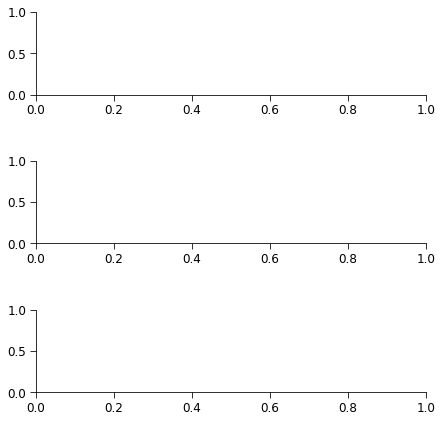

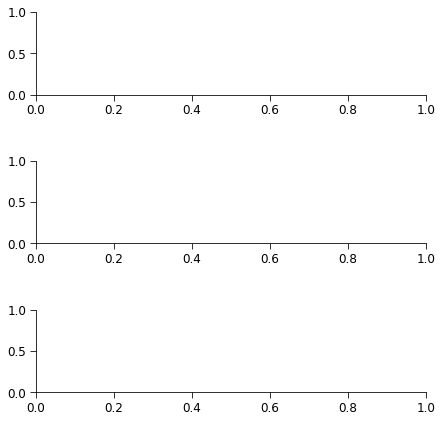

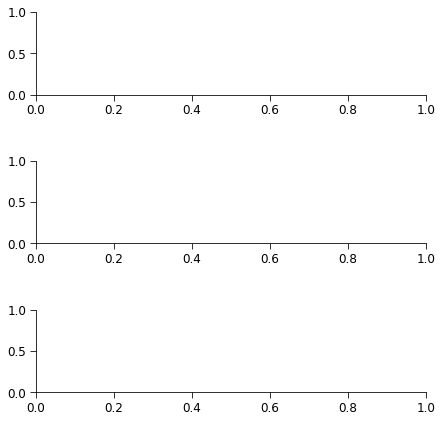

In [19]:
pdf = PdfPages('comparison.pdf')

sweeps = [42,75,77]
for sweep in sweeps:
    print('plotting sweep: ', sweep)
    
    fig, axs = plt.subplots(nrows=3, figsize=(7,7))     
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.8)
    
    try:
        target = dset.get_sweep(sweep)['response']  * 1000
        allen_response = fitted_allen_nwb.get_sweep(sweep)['response']  * 1000
        stim = fitted_allen_nwb.get_sweep(sweep)['stimulus']  * 1e9
        cmpre_response = responses[sweep]
        dt =  1000/dset.get_sweep(sweep)['sampling_rate']
    except:
        continue
    
    stim_ax = axs[0]
    stim_ax.plot(np.arange(len(stim))*dt*.001, stim, color='black', label='stim')
    stim_ax.legend(loc=(.9,.8))
    # stim_ax.set_xlabel('time (s)', fontsize=14)
    stim_ax.set_ylabel("$\mu$A",fontsize=14)
    stim_ax.set_title(f'Stim {sweep}', fontsize=14)
    stim_ax.spines['top'].set_visible(False)
    stim_ax.spines['right'].set_visible(False)
    
    [ax.set_xlim(0,4) for ax in axs]

    
    
    ax_plot_response(cmpre_response, target, axs[1], dt, 'CoMParE')
    ax_plot_response(allen_response, target, axs[2], dt, 'Allen', legend=False)
    
    
    

        
    fig.suptitle(f"Sweep {sweep} ", y = 1, fontsize=16)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

pdf.close()